# Signature
This was done as part of the WEL project. 

On that project I was using the `TurbulenceProfilerClass`

`from turbo_tools.classes.adcp_object import TurbulenceProfilerClass`

This is initialised as:

`tpo = TurbulenceProfilerClass(ds.time.values, ds.distance.values, ds.Eastvel_Nortek.values.transpose(), ds.Northvel_Nortek.values.transpose(), ds.Upvel_Nortek.values.transpose(), ds.beam5amp.values.transpose(), fs=4)`

The ds there was produced by:
1. Signature software export to mat [many small files]
1. Matlab convert all of the signature files to nc
2. Read the nc s in xarray

I need something with fewer steps. Kilcher's Dolfyn may be the solution here. 



In [1]:
import xarray as xr
from turbo_tools.utils import time as turbo_utils_time
import matplotlib.pyplot as plt

import importlib
import datetime
import turbo_tools
import numpy as np
from turbo_tools.classes.adcp_object import TurbulenceProfilerClass

from os import listdir
import os

from zutils.time import num2date_lk as num2date_lk

ModuleNotFoundError: No module named 'turbo_tools'

In [4]:
import dolfyn as dlfn
nens = 100000000

# This will be a 5 beam NB Doppler file
# dat = dlfn.read(r'Y:\DATA\FIELD\browse-basin-kissme\Data\NortekSignature\S100460A008_KISSME_CB.ad2cp', nens=nens)

# This will be a 5 beam PC Doppler file
if False:
    hasb = 0.35;
    dat = dlfn.read(r'../KISSME samples/Nortek Signature/S100460A018_PILBRA19.ad2cp', nens=[0, 3000])
elif False:
    pass
else:
#     dat = dlfn.read(r'E:\Experiments\kissme17\sp250l\signature1000\S100460A008_KISSME_CB.ad2cp', rebuild_index=False)

    hasb = 0.35;
    
    # Deployment
    start = 24*30000
    end   = 40*30000
    
    # Apr-2 wave
    start = 50*30000
    end   = 55*30000
    
    # Apr-3 wave
    start = 50*30000+700000
    end   = 55*30000+750000
    
    dat = dlfn.read(r'E:\Experiments\kissme17\sp250l\signature1000\S100460A008_KISSME_CB.ad2cp', nens=[start, start+2], rebuild_index=False)
    print(num2date_lk(dat.mpltime[0]))
    print(num2date_lk(dat.mpltime[-1]))
    print('{} hours in record.'.format((dat.mpltime[-1]-dat.mpltime[0])*24))
    
    dat = dlfn.read(r'E:\Experiments\kissme17\sp250l\signature1000\S100460A008_KISSME_CB.ad2cp', nens=[end, end+2], rebuild_index=False)
    print(num2date_lk(dat.mpltime[0]))
    print(num2date_lk(dat.mpltime[-1]))
    print('{} hours in record.'.format((dat.mpltime[-1]-dat.mpltime[0])*24))
    
    dat = dlfn.read(r'E:\Experiments\kissme17\sp250l\signature1000\S100460A008_KISSME_CB.ad2cp', nens=[start, end], rebuild_index=False)
    print(num2date_lk(dat.mpltime[0]))
    print(num2date_lk(dat.mpltime[-1]))
    print('{} hours in record.'.format((dat.mpltime[-1]-dat.mpltime[0])*24))
    

Reading 2 ensembles [2200000-2200002] from file  %s ...
2017-04-03 05:23:20.063301
2017-04-03 05:23:20.188496
3.477651625871658e-05 hours in record.
Reading 2 ensembles [2450000-2450002] from file  %s ...
2017-04-03 14:04:10.063302
2017-04-03 14:04:10.188598
3.480445593595505e-05 hours in record.
Reading 250000 ensembles [2200000-2450000] from file  %s ...
2017-04-03 05:23:20.063301
2017-04-03 14:04:09.938499
8.68052088841796 hours in record.


In [5]:
print(num2date_lk(dat.mpltime[0]))
print(num2date_lk(dat.mpltime[-1]))
print('{} hours in record.'.format((dat.mpltime[-1]-dat.mpltime[0])*24))

dat.config

2017-04-03 05:23:20.063301
2017-04-03 14:04:09.938499
8.68052088841796 hours in record.


Nortek AD2CP Configuration:
  *------------
  | SerialNum                : 100460
  | SerialNum_b5             : 100460
  | TransMatrix              : <class 'numpy.ndarray'>
  | blanking                 : 0.1
  | blanking_b5              : 0.1
  | cell_size                : 0.2
  | cell_size_b5             : 0.2
  | coord_sys                : BEAM
  | coord_sys_b5             : BEAM
  | data_desc                : 17185
  | data_desc_b5             : 5
  | fs                       : 8
  | model                    : Signature1000
  | nbeams                   : 4
  | nbeams_b5                : 1
  | ncells                   : 115
  | ncells_b5                : 115
  | nom_corr                 : 22
  | nom_corr_b5              : 21
  | power_level              : 0
  | power_level_b5           : 0
  | vel_scale                : -3
  | vel_scale_b5             : -3
  > + burst_config
    | ahrs                     : False
    | alt                      : False
    | alt_raw                 

In [7]:
if not "mpltime_b5" in dat:
    raise(Exception("4 beam files not handled."))
    
b5_lag = dat.mpltime-dat.mpltime_b5
if any(b5_lag>1/15):
    raise(Exception("Something wrong with b5 lag."))

if not len(dat.range)==len(dat.range_b5) or not all(dat.range==dat.range_b5):
    raise(Exception("Handling range!= range_b5 is not handled."))
    
if not dat.config.coord_sys=="BEAM" or not dat.config.coord_sys_b5=="BEAM":
    raise(Exception("BEAM data only handled."))
    

In [93]:
nc = dat.vel.shape[1]
nt = dat.vel.shape[2]

blank1 = np.nan*np.zeros((nc, nt))
blank3 = np.nan*np.zeros((3, nc, nt))

blank1.shape

(115, 250000)

In [105]:
dat.signal                   

<class 'dolfyn.data.base.TimeData'>: Data Object with Keys:
  *------------
  | amp                      : <array; (4, 115, 250000); float16>
  | amp_b5                   : <array; (1, 115, 250000); float16>
  | corr                     : <array; (4, 115, 250000); uint8>
  | corr_b5                  : <array; (1, 115, 250000); uint8>

In [108]:
print('Converting mpltime to date. Expect delays!')
time = dat.mpltime
time_datetime = num2date_lk(time[0]) + np.cumsum(np.array([datetime.timedelta(days=0)] + [datetime.timedelta(days=x) for x in np.diff(time)]))
print('Converted.')
print('     Starts: {}'.format(time_datetime[0]))
print('     Ends: {}'.format(time_datetime[-1]))
print('     How were those delays?')

nc = dat.vel.shape[1]
nt = dat.vel.shape[2]

blank1 = np.nan*np.zeros((nc, nt))
blank3 = np.nan*np.zeros((3, nc, nt))

vel_dolfyn = np.concatenate((dat.vel, dat.vel_b5))
echo = np.concatenate((dat.signal.amp, dat.signal.amp_b5))
corr = np.concatenate((dat.signal.corr, dat.signal.corr_b5))

ds = xr.Dataset({'vel_dolfyn': (['beam', 'height', 'time'], vel_dolfyn),
            'vel_enu': (['cartesian_axes', 'height', 'time'], blank3),
            'vel_xyz': (['cartesian_axes', 'height', 'time'], blank3),
            'four_beam_error_velocity': (['height', 'time'], blank1),
            'pressure': ('time', dat.env.press),
            'temperature': ('time', dat.env.temp),
            'speed_of_sound': ('time', dat.env.c_sound),
            'heading': (['time'], dat.orient.raw.heading),
            'pitch': (['time'], dat.orient.raw.pitch),
            'roll': (['time'], dat.orient.raw.roll),
            'echo': (['beam', 'height', 'time'], echo), 
            'corr': (['beam', 'height', 'time'], corr),
            'mpltime': ('time', dat.mpltime),
            'distance': ('height', np.arange(0, nc)),
            'cell': ('height', np.arange(0, nc))},
            coords={'beam': np.arange(1, 6), 'cartesian_axes': np.arange(1, 4), 'height': np.arange(0, nc), 'time': time_datetime})


Converting mpltime to date. Expect delays!
Converted.
     Starts: 2017-04-03 05:23:20.063301
     Ends: 2017-04-03 14:04:09.892061
     How were those delays?


2017-04-03 05:23:20.063301


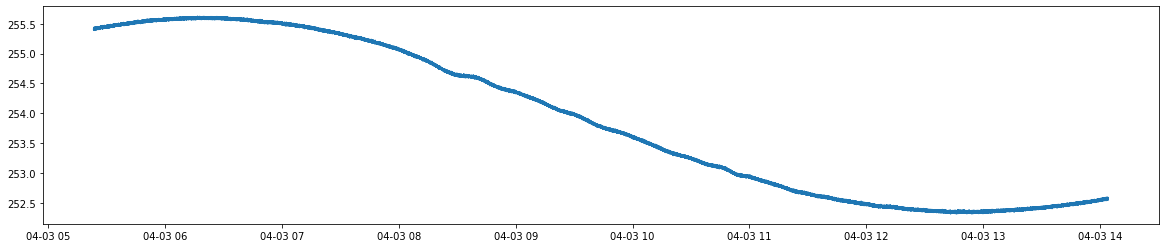

In [109]:
plt.figure(figsize=(20, 4))
print(time_datetime[0])
plt.plot(time_datetime, ds.pressure)

In [110]:
coords = dat.config.coord_sys                
ds.vel_dolfyn.attrs['standard_name'] = '{}_seawater_velocity'.format(coords) 
ds.vel_dolfyn.attrs['long_name'] = 'Velocity output by Dolfyn package when reading the .vec file with no key word arguments. Coord sys was {}'.format(coords) 
ds.vel_dolfyn.attrs['units'] = 'm/s' 

ds.vel_xyz.attrs['standard_name'] = 'XYZZ_seawater_velocity'
ds.vel_xyz.attrs['long_name'] = 'Instrument coordinate [XYZZ] velocity. Conventions are nortek conventions.'
ds.vel_xyz.attrs['units'] = 'm/s' 

ds.vel_enu.attrs['standard_name'] = 'ENU_seawater_velocity'
ds.vel_enu.attrs['long_name'] = 'Earth coordinate [ENU] velocity. '
ds.vel_enu.attrs['units'] = 'm/s' 

ds.pressure.attrs['standard_name'] = 'pressure' 
ds.pressure.attrs['long_name'] = 'pressure' 
ds.pressure.attrs['units'] = 'dbar' 

ds.temperature.attrs['standard_name'] = 'seawater_temperature' 
ds.temperature.attrs['long_name'] = 'seawater_temperature' 
ds.temperature.attrs['units'] = 'deg' 

ds.speed_of_sound.attrs['standard_name'] = 'speed_of_sound' 
ds.speed_of_sound.attrs['long_name'] = 'Speed of sound used by the instrument to estimate range etc.' 
ds.speed_of_sound.attrs['units'] = 'm/s' 

ds.distance.attrs['standard_name'] = 'distance_between_cell_and_instrument' 
ds.distance.attrs['long_name'] = 'distance between cell and instrument, positive away from instrument' 
ds.distance.attrs['units'] = 'm' 

ds.height.attrs['standard_name'] = 'height_above_seabed' 
ds.height.attrs['long_name'] = 'Height above seabed, positive upwards' 
ds.height.attrs['units'] = 'm' 

# Specify variables which will not be CF compliant. 
ds['heading'].attrs['cf_compliant'] = 0
ds['pitch'].attrs['cf_compliant'] = 0
ds['roll'].attrs['cf_compliant'] = 0
ds['echo'].attrs['cf_compliant'] = 0
ds['corr'].attrs['cf_compliant'] = 0
ds.time.attrs['cf_compliant'] = 0
ds.beam.attrs['cf_compliant'] = 0

attrs = {}
attrs['config:SerialNum'] = dat.config.SerialNum
attrs['config:SerialNum_b5'] = dat.config.SerialNum_b5
attrs['config:fs'] = dat.config.fs
attrs['config:blanking'] = dat.config.blanking
attrs['config:blanking_b5'] = dat.config.blanking_b5
attrs['config:cell_size'] = dat.config.cell_size
attrs['config:cell_size_b5'] = dat.config.cell_size_b5
attrs['config:coord_sys'] = dat.config.coord_sys
attrs['config:coord_sys_b5'] = dat.config.coord_sys_b5
attrs['config:data_desc'] = dat.config.data_desc
attrs['config:data_desc_b5'] = dat.config.data_desc_b5
attrs['config:model'] = dat.config.model
attrs['config:nbeams'] = dat.config.nbeams
attrs['config:nbeams_b5'] = dat.config.nbeams_b5
attrs['config:ncells'] = dat.config.ncells
attrs['config:ncells_b5'] = dat.config.ncells_b5
attrs['config:nom_corr'] = dat.config.nom_corr
attrs['config:nom_corr_b5'] = dat.config.nom_corr_b5
attrs['config:power_level'] = dat.config.power_level
attrs['config:power_level_b5'] = dat.config.power_level_b5
attrs['config:vel_scale'] = dat.config.vel_scale
attrs['config:vel_scale_b5'] = dat.config.vel_scale_b5

attrs['config:TransMatrix'] = np.array2string(dat.config.TransMatrix)
attrs['config:head:TransMatrix_howToTeadInNumpy'] = "T=T.replace('[','');T=T.replace(']','');T=np.fromstring(T, dtype=float, sep=' ').reshape((4, 4))"

ds.attrs = attrs

ds['distance'] = ds.cell*attrs['config:cell_size']+attrs['config:blanking']
ds['height'] = ds.cell*attrs['config:cell_size']+attrs['config:blanking'] + hasb
# self.dat = dat
# self.ds = ds

# # Associate some QC flags
# self.associate_qc_flag('vel_dolfyn', 'velocity')
# self.associate_qc_flag('temperature', 'temperature')
# self.associate_qc_flag('pressure', 'pressure')
# self.associate_qc_flag('heading', 'compass')
# self.associate_qc_flag('pitch', 'tilt')
# self.associate_qc_flag('roll', 'tilt')

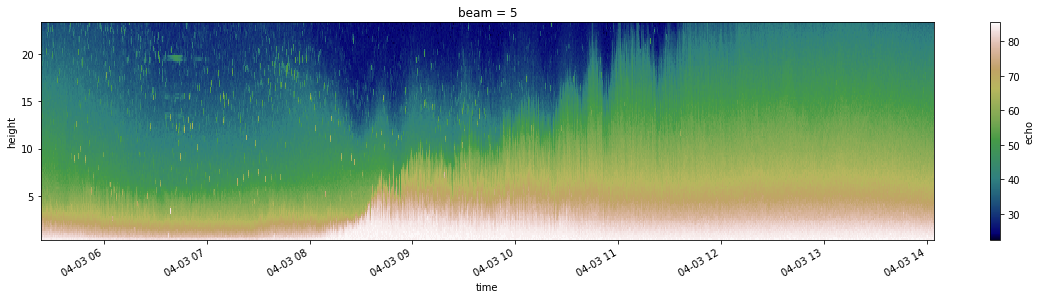

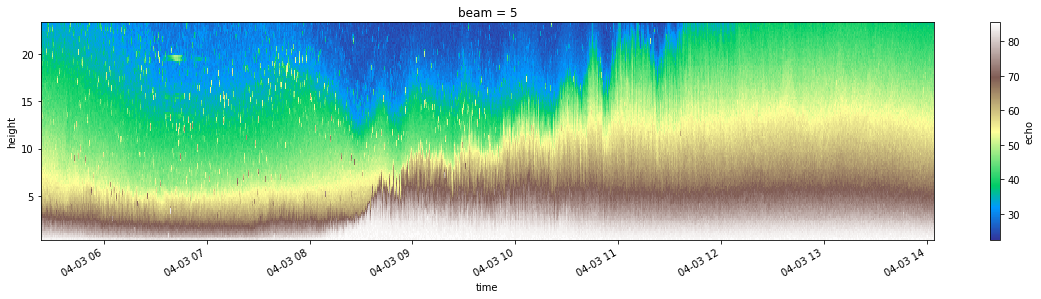

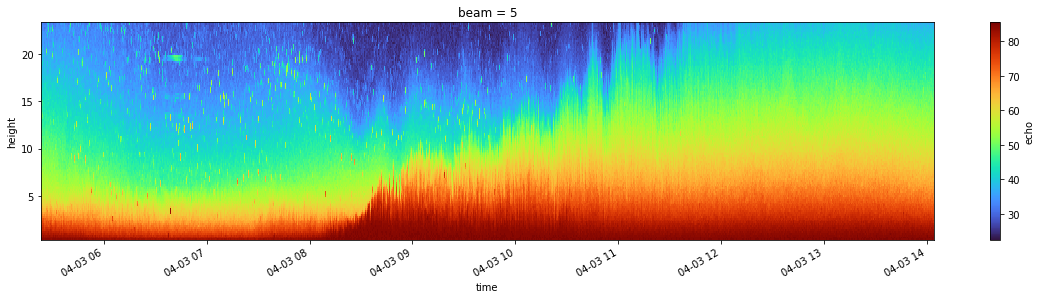

In [111]:
plt.figure(figsize=(20, 4))
ds.echo[4, :, :].plot(cmap='gist_earth')
plt.show()

plt.figure(figsize=(20, 4))
ds.echo[4, :, :].plot(cmap='terrain')
plt.show()

plt.figure(figsize=(20, 4))
ds.echo[4, :, :].plot(cmap='turbo')
plt.show()

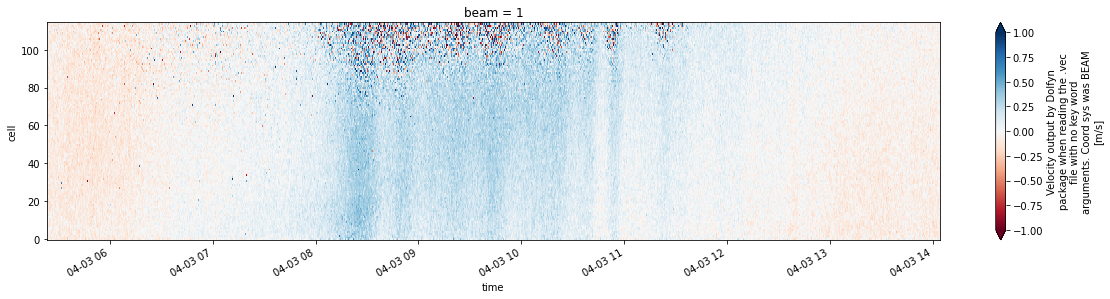

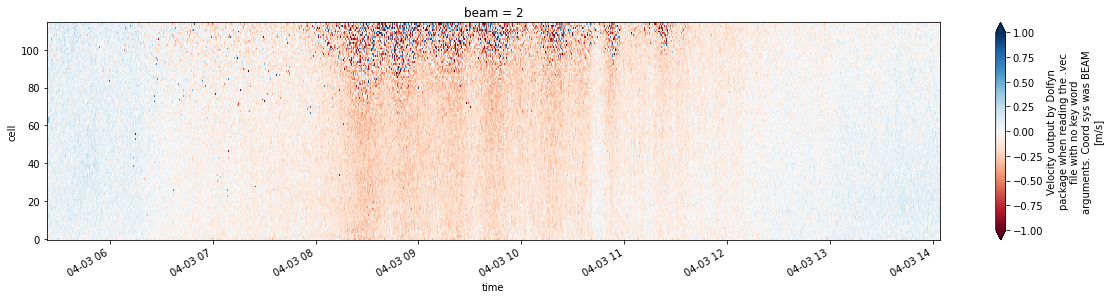

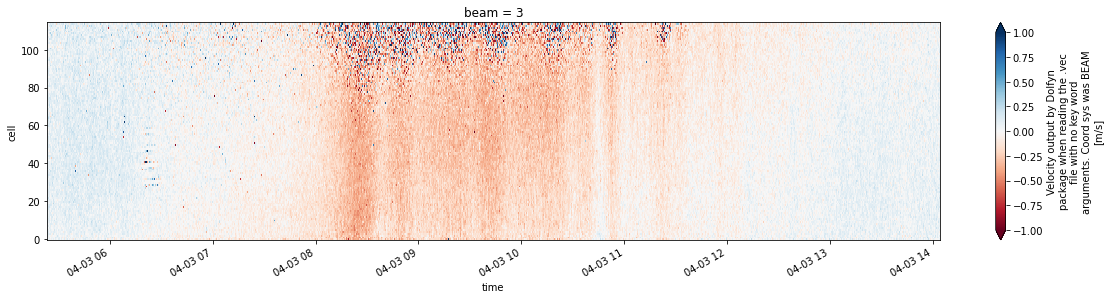

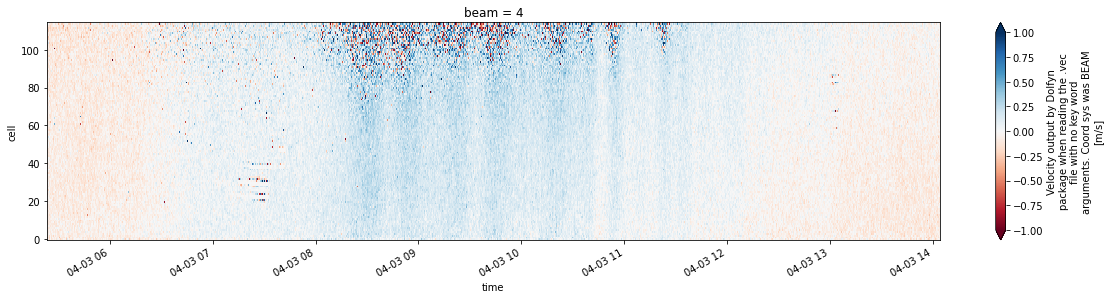

In [13]:

plt.figure(figsize=(20, 4))
ds.vel_dolfyn[0, :, :].plot(vmin=-1, vmax=1, cmap='RdBu')
plt.show()

plt.figure(figsize=(20, 4))
ds.vel_dolfyn[1, :, :].plot(vmin=-1, vmax=1, cmap='RdBu')
plt.show()

plt.figure(figsize=(20, 4))
ds.vel_dolfyn[2, :, :].plot(vmin=-1, vmax=1, cmap='RdBu')
plt.show()

plt.figure(figsize=(20, 4))
ds.vel_dolfyn[3, :, :].plot(vmin=-1, vmax=1, cmap='RdBu')
plt.show()


In [35]:
T  = attrs['config:TransMatrix']
T = T.replace('[','');T=T.replace(']','');T=np.fromstring(T, dtype=float, sep=' ').reshape((4, 4))
T


array([[ 1.1831,  0.    , -1.1831,  0.    ],
       [ 0.    , -1.1831,  0.    ,  1.1831],
       [ 0.5518,  0.    ,  0.5518,  0.    ],
       [ 0.    ,  0.5518,  0.    ,  0.5518]])

In [116]:
nc = ds.vel_dolfyn.shape[1]
XYZZ = np.zeros_like(ds.vel_dolfyn[0:4, :, :])

for i in np.arange(0, nc):
    XYZZ[:, i, :] = np.matmul(T, ds.vel_dolfyn.values[0:4, i, :])
    # XYZ = np.matmul(T, T)
    
four_beam_error_velocity = XYZZ[2, :, :]-XYZZ[3, :, :]
XYZZ[2, :, :] = (XYZZ[2, :, :]+XYZZ[3, :, :])/2

ds.vel_xyz.values = XYZZ[0:3, :, :]

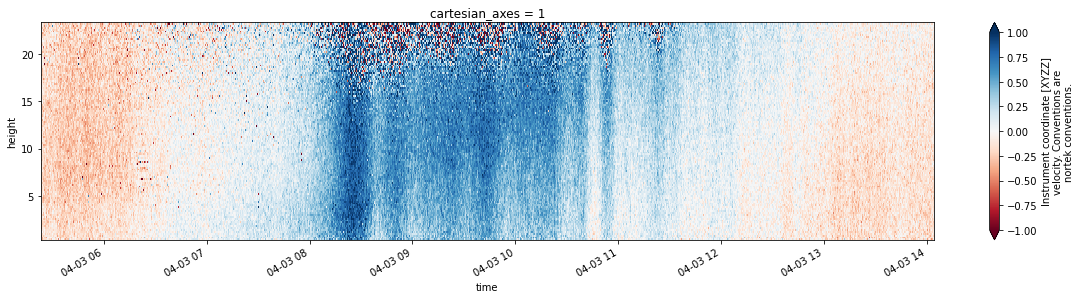

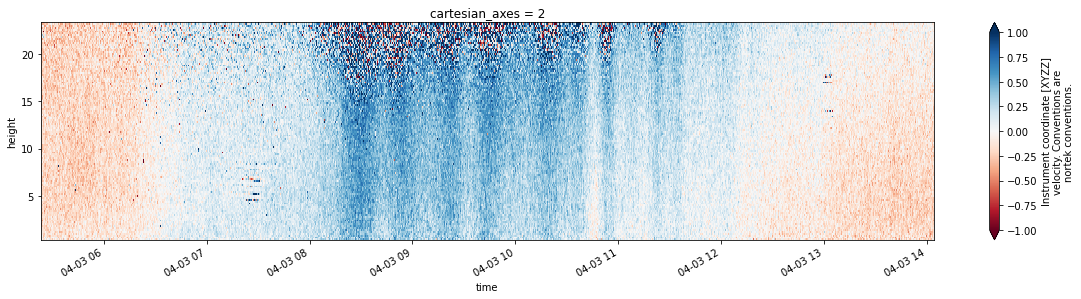

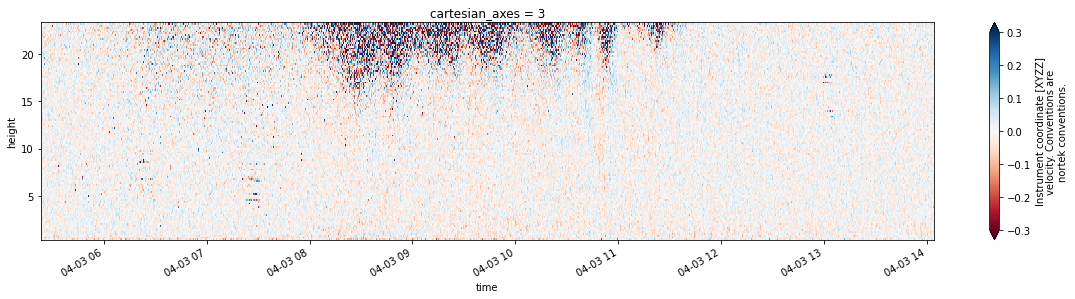

In [117]:
plt.figure(figsize=(20, 4))
ds.vel_xyz[0, :, :].plot(vmin=-1, vmax=1, cmap='RdBu')
plt.show()

plt.figure(figsize=(20, 4))
ds.vel_xyz[1, :, :].plot(vmin=-1, vmax=1, cmap='RdBu')
plt.show()

plt.figure(figsize=(20, 4))
ds.vel_xyz[2, :, :].plot(vmin=-0.3, vmax=0.3, cmap='RdBu')
plt.show()


# Nortek notes on transforms
There are a couple of Matlab codes in there too.  

https://support.nortekgroup.com/hc/en-us/articles/360029820971-How-is-a-coordinate-transformation-done-

https://nortek.zendesk.com/attachments/token/g3Xal028bJkYclRph8hRdlIR2/?name=signatureAD2CP_beam2xyz_enu.m

In [118]:
hh = (dat.orient.raw.heading-90)*np.pi/180
pp = (dat.orient.raw.pitch)*np.pi/180
rr = (dat.orient.raw.roll)*np.pi/180

if True: # Speed up for fixed instrument
    hh = np.mean(hh)
    pp = np.mean(pp)
    rr = np.mean(rr)
else:
    raise(Exception)

# % Make heading matrix
H = np.array([[np.cos(hh), np.sin(hh), 0],[ -np.sin(hh), np.cos(hh), 0],[0, 0, 1]])

# % Make tilt matrix
P = np.array([[np.cos(pp), -np.sin(pp)*np.sin(rr), -np.cos(rr)*np.sin(pp)],
     [0, np.cos(rr), -np.sin(rr)],  
     [np.sin(pp), np.sin(rr)*np.cos(pp),  np.cos(pp)*np.cos(rr)]])

# % Make resulting transformation matrix
xyz2enu = np.matmul(H, P)
# if (twoZs == 1)
#   xyz2enu(1,3) = xyz2enu(1,3)/2;
#   xyz2enu(1,4) = xyz2enu(1,3);
#   xyz2enu(2,3) = xyz2enu(2,3)/2;
#   xyz2enu(2,4) = xyz2enu(2,3);

#   xyz2enu(4,:) = xyz2enu(3,:);
#   xyz2enu(3,4) = 0;
#   xyz2enu(4,4) = xyz2enu(3,3);
#   xyz2enu(4,3) = 0;
# end

xyz2enu.shape

(3, 3)

In [123]:
ds.vel_enu

<xarray.DataArray 'vel_enu' (cartesian_axes: 3, height: 115, time: 250000)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * cartesian_axes  (cartesian_axes) int32 1 2 3
  * height          (height) float64 0.45 0.65 0.85 1.05 ... 22.85 23.05 23.25
  * time            (time) datetime64[ns] 2017-04-03T05:23:20.063301 ... 2017...

In [124]:
ENU = np.zeros_like(ds.vel_xyz[:, :, :])

for i in np.arange(0, nc):
    ENU[0:3, i, :] = np.matmul(xyz2enu, ds.vel_xyz.values[:, i, :])
    # XYZ = np.matmul(T, T)
    
ds.vel_enu.values = ENU

ds['ENU'] = da_ENU
ds['XYZZ'] = da_XYZZ

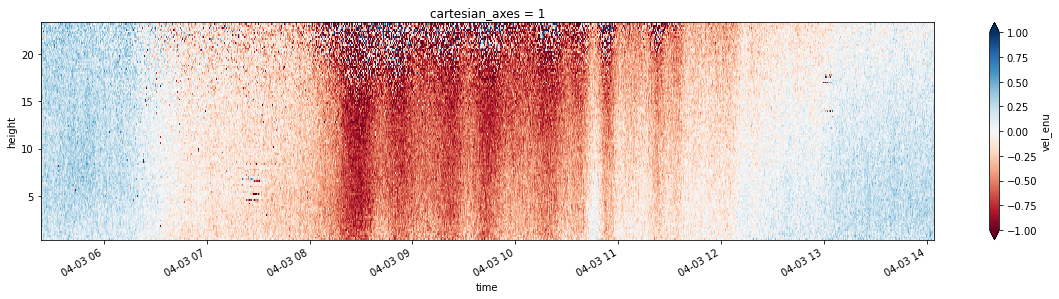

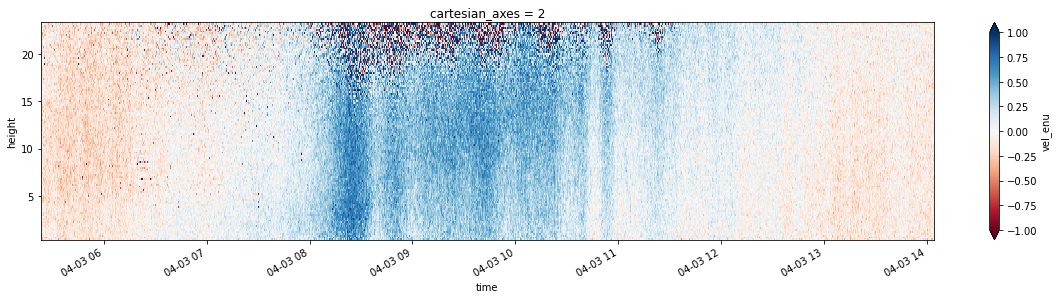

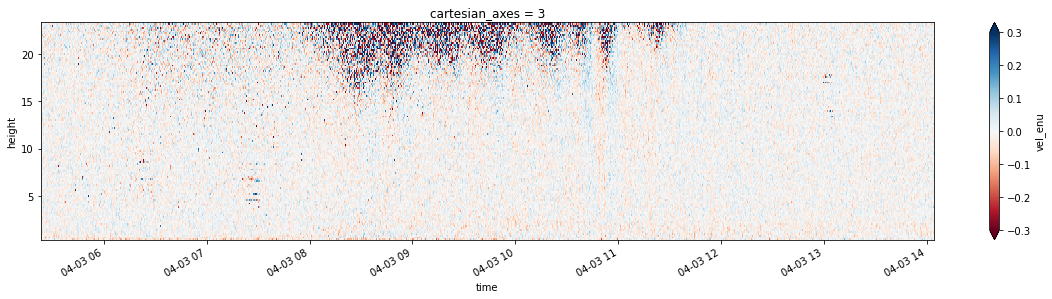

In [125]:
plt.figure(figsize=(20, 4))
ds.vel_enu[0, :, :].plot(vmin=-1, vmax=1, cmap='RdBu')
plt.show()

plt.figure(figsize=(20, 4))
ds.vel_enu[1, :, :].plot(vmin=-1, vmax=1, cmap='RdBu')
plt.show()

plt.figure(figsize=(20, 4))
ds.vel_enu[2, :, :].plot(vmin=-0.3, vmax=0.3, cmap='RdBu')
plt.show()


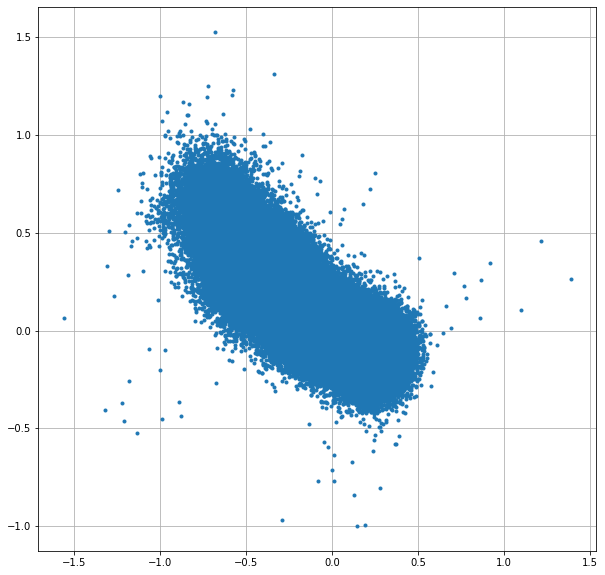

In [47]:
plt.figure(figsize=(10,10))
plt.plot(ds.vel_enu[0, 10, :], ds.vel_enu[1, 10, :], '.')
plt.grid()

# Now revisit the ADP object

In [131]:
from turbo_tools.classes.adcp_object import TurbulenceProfilerClass as TPO

import importlib
importlib.reload(turbo_tools.classes.adcp_object)
from turbo_tools.classes.adcp_object import TurbulenceProfilerClass as TPO


In [139]:
tpo = TPO(ds.time, ds.height, ds.vel_enu[0, :, :], ds.vel_enu[1, :, :], ds.vel_enu[2, :, :], ds.echo[4, :, :], fs=8)

Initialising with length 250000
Initialised.
<class 'numpy.datetime64'>
Time vector is well spaced


In [147]:
tpo.re_avg()
tpo.ds

<xarray.Dataset>
Dimensions:        (height: 115, mean_time: 516, time: 250000)
Coordinates:
  * height         (height) float64 0.45 0.65 0.85 1.05 ... 22.85 23.05 23.25
  * mean_time      (mean_time) datetime64[ns] 2017-04-03T05:25:50.063220 ... ...
  * time           (time) datetime64[ns] 2017-04-03T05:23:20.063301 ... 2017-...
Data variables:
    vel_e_raw      (height, time) float32 0.1868 0.2112 ... 0.08092 0.1213
    vel_n_raw      (height, time) float32 -0.07006 -0.09509 ... 0.2137 0.03015
    vel_u_raw      (height, time) float32 0.009595 0.0176 ... 0.06263 -0.05087
    vel_e          (height, time) float32 0.1868 0.2112 ... 0.08092 0.1213
    vel_n          (height, time) float32 -0.07006 -0.09509 ... 0.2137 0.03015
    vel_u          (height, time) float32 0.009595 0.0176 ... 0.06263 -0.05087
    beam5amp       (height, time) float16 84.5 84.5 84.5 84.5 ... 37.0 37.5 37.0
    mean_vel_e     (height, mean_time) float64 0.1744 0.1784 ... 0.03519 0.03452
    mean_vel_n     (height, mean_time) float64 -0.1001 -0.1029 ... -0.04079
    mean_vel_u     (height, mean_time) float64 -0.01472 -0.0166 ... 0.001478
    mean_beam5amp  (height, mean_time) float64 inf inf inf inf ... inf inf inf

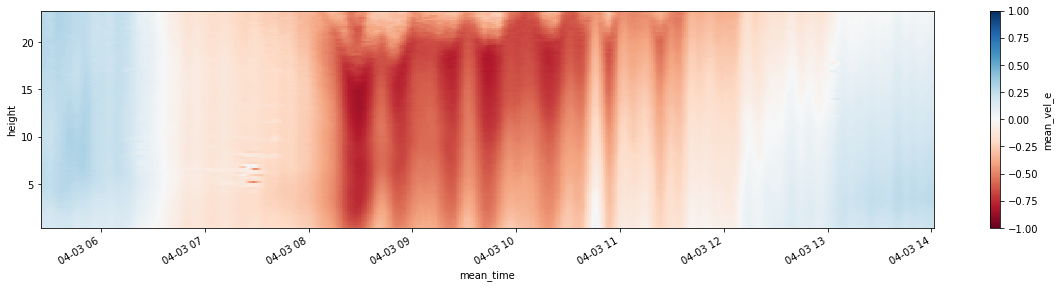

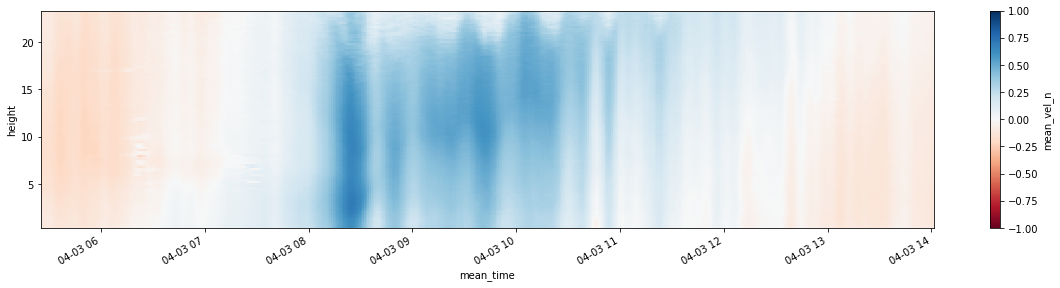

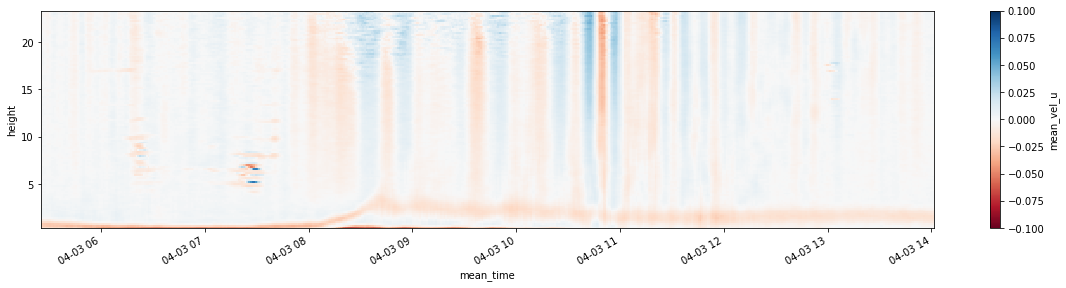

In [146]:
plt.figure(figsize=(20, 4))
tpo.ds.mean_vel_e.plot(vmin=-1, vmax=1, cmap='RdBu')
plt.show()

plt.figure(figsize=(20, 4))
tpo.ds.mean_vel_n.plot(vmin=-1, vmax=1, cmap='RdBu')
plt.show()

plt.figure(figsize=(20, 4))
tpo.ds.mean_vel_u.plot(vmin=-0.1, vmax=0.1, cmap='RdBu')
plt.show()


# Need to copy over all of the QC measures from Matlab to Python

1. Phase wrapping [DONE]
1. Goring Nikora [DONE]
1. The fish detection that doesn't get tricked vy turbulent billows at the top of the BBL
1. Threshold based QAQC
